# Interpolate the numerical accuracy threshold search results

[Alexander Pitchford](http://github.com/ajgpitch), [Benjamin Dive](mailto:benjamindive@gmail.com)

Interpolate the numerical accuracy search data to determine the threshold at which it starts to reduce the pulse optimisation success below some specified value (typically 50%)

It will look for data files in a directory specified by:
    `data_dir/result_subdir`
    
This can be an absolute path or relative to the current working directory or relative to the user home directory by starting data_dir with `~/`.

A collated results file will be looked for that must match the pattern:
 `coll_file_pat = "nal_collate*.txt"`

Some parameters used for the optimisations are also needed. These will first be looked for in a file:
    `interp_fname = "interp.dat"`. 
    
If this is not present then it will look for a parameter file matching:
    `param_file_pat = "params*.ini"`

The data are interpolated using `numpy.polyfit`. This gives a line of best fit with gradient and an intercept, with variance on both. Hence these can be used to estimate the threshold and it's uncertianty. Although the data would seem to look more Gaussian than linear, linear would seem to be a good approximation around the 50% threshold. This method would probably not be reliable for estimating high (e.g. 90%) or low (e.g. 10%) thresholds. However, the objective is to look for a trend as system size grows, so the choice of success proportion threshold is somehow arbitary, so long as it is reliable and consistent. A similar interpolation is used to estimate the number of iterations required on average to optimise pulses if the numerical accuracy was at the threshold level.

The results are shown in two plots. These show the data points, trend lines, and the threshold points are marked with error bars, which illustrate the uncertainty.

As the data at the extremes of success proportion are not expected to fit the linear model, then these are excluded from the interpolation. For the first attempt these exclusion boundaries are estimated based on the fidelity
error target. It is possible to change them interactively using input box.

The parameters used, iterpolation results, and exclusion boundaries are saved in the 
 `interp_fname = "interp.dat"` 
file. So if the notebook is re-run, then the exclusion boundaries are rememebered. Also the plots are saved to file.

In [1]:
%matplotlib inline
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import qsoconfig
import qsoresult

## Configuration

In [2]:
data_dir = "example_output"
result_subdir = "3qubit-chain-ising_equal-xy_ctrl-cNOT1-sens-nq3fet1e-3-try4"

# These below are the default output directories for the script and notebook that produce the data
#data_dir = "output/optim_CNOT"
#result_subdir = "nal"
param_file_pat = "params*.ini"
coll_file_pat = "nal_collate*.txt"
interp_fname = "interp.dat"
plot_fname = "interplot.png"
verbosity = 1



## Loading the result data

In [3]:
if '~' in data_dir:
    data_dir = os.path.expanduser(data_dir)
elif not os.path.abspath(data_dir):
    # Assume relative path from cwd given
    data_dir = os.path.join(os.getcwd(), data_dir)

res_dir = os.path.join(data_dir, result_subdir)

print("Results dir:\n{}".format(res_dir))
if not os.path.isdir(res_dir):
    raise RuntimeError("Results dir not valid")

# look for files to read existing results
coll_na = {}
na_list = []

if verbosity > 0:
    print("Searching in:\n{}".format(res_dir))
    print("Looking for collation file matching {}\n".format(coll_file_pat))
files = glob.glob(os.path.join(res_dir, coll_file_pat))

if len(files) == 0:
    print("No collation file to process")

plot_fpath = os.path.join(res_dir, plot_fname)

# Take the most recent file, assume last in list
collf = sorted(files)[-1]
if verbosity > 0:
    print("Loading collation from file:\n{}\n".format(collf))
reslist = qsoresult.MultiRepResult.load_from_txt(collf)
for na_res in reslist:
    na_list.append(na_res.numer_acc)
    coll_na[na_res.numer_acc] = na_res

na_arr = np.array(sorted(na_list))
succ_props = []
num_iters = []
for na in na_arr:
    na_res = coll_na[na]
    succ_props.append(float(na_res.num_primary_success) / na_res.num_res)
    num_iters.append(na_res.mean_iter_primary_success)
    fid_err_targ = na_res.fid_err_targ

succ_arr = np.array(succ_props)
iter_arr = np.array(num_iters)
na_lim = na_arr[-1]*1.2

# Look for previous interp results file
interp_fpath = os.path.join(res_dir, interp_fname)
if os.path.isfile(interp_fpath):
    if verbosity > 0:
        print("Loading interp params from:\n{}\n".format(interp_fpath))
    data = np.loadtxt(interp_fpath)
    # Note num_qubits only added to the file 2018-04-13
    # interp files from before that will need number of qubits inserting
    nq = int(data[0])
    na_lb = data[1]
    na_ub = data[2]
    try:
        succ_thresh = data[3]
    except:
        succ_thresh = 0.5
else:
    # No interp results file, look for a parameter file
    param_pat = os.path.join(res_dir, param_file_pat)
    if verbosity > 0:
        print("Looking for parameter file matching:\n{}".format(param_pat))
    files = glob.glob(param_pat)
    n_files = len(files)
    if n_files == 0:
        print("NO PARAMETER FILES FOUND!")
        raise RuntimeError("No parameter file")
    print("Loading configuration from:\n{}".format(files[0]))
    optim = qsoconfig.gen_config(files[0])
    dyn = optim.dynamics
    tc = optim.termination_conditions
    fid_comp = optim.dynamics.fid_computer
    nq = dyn.num_qubits
    if not fid_comp.numer_acc_exact:
        fid_comp.st_numer_acc = round_sigfigs(
                fid_comp.st_numer_acc*fid_err_targ/tc.fid_err_targ, 6)
        fid_comp.end_numer_acc = round_sigfigs(
                fid_comp.end_numer_acc*fid_err_targ/tc.fid_err_targ, 6)

    na_lb = fid_comp.st_numer_acc
    na_ub = fid_comp.end_numer_acc
    succ_thresh = 0.5



Results dir:
example_output/3qubit-chain-ising_equal-xy_ctrl-cNOT1-sens-nq3fet1e-3-try4
Searching in:
example_output/3qubit-chain-ising_equal-xy_ctrl-cNOT1-sens-nq3fet1e-3-try4
Looking for collation file matching nal_collate*.txt

Loading collation from file:
example_output/3qubit-chain-ising_equal-xy_ctrl-cNOT1-sens-nq3fet1e-3-try4/nal_collate_qso-pure_Choi_local-chain-Ising-XY-CNOT-nq3.j1496816.txt

Loading interp params from:
example_output/3qubit-chain-ising_equal-xy_ctrl-cNOT1-sens-nq3fet1e-3-try4/interp.dat



Numerical accuracy threshold calculated:
50.0% thresh=3.237e-05 +/- 2.23e-06

Mean interations and combined error for numerical accuracy threshold calculated:
na_thresh_iter=5.684e+01 +/- 1.56e+00

Numerical accuracy result bounds: lower 0.0, upper 5e-05


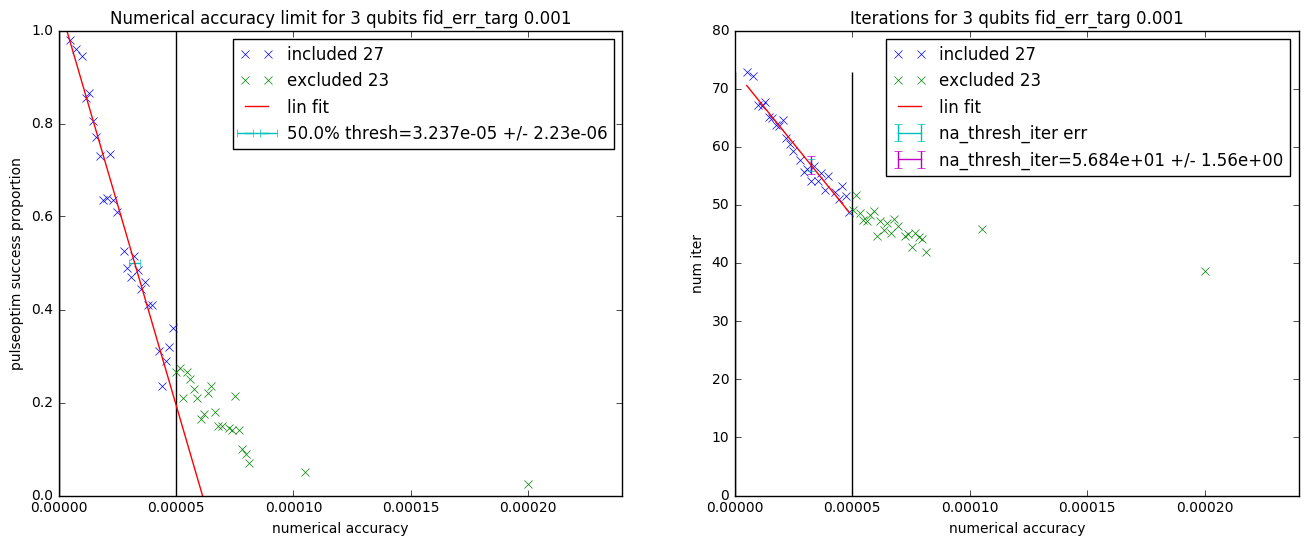

In [4]:
fig = plt.figure(figsize=(16,6))

sel = (na_arr > na_lb) & (na_arr < na_ub)
sel_na = na_arr[sel]
other_na = na_arr[~sel]
sel_succ = succ_arr[sel]
other_succ = succ_arr[~sel]
sel_iter = iter_arr[sel]
other_iter = iter_arr[~sel]

fig.clear()
ax1 = fig.add_subplot(121)
ax1.plot(sel_na, sel_succ, 'x', label='included {}'.format(len(sel_na)))
ax1.plot(other_na, other_succ, 'x', label='excluded {}'.format(len(other_na)))
ax1.vlines([na_lb, na_ub], 0, 1)
ax1.set_xlim(0, na_lim)
ax1.set_title("Numerical accuracy limit for {} "
             "qubits fid_err_targ {}".format(nq, fid_err_targ))
ax1.set_xlabel("numerical accuracy")
ax1.set_ylabel("pulseoptim success proportion")

ax2 = fig.add_subplot(122)
ax2.plot(sel_na, sel_iter, 'x', label='included {}'.format(len(sel_na)))
ax2.plot(other_na, other_iter, 'x', label='excluded {}'.format(len(other_na)))
ax2.vlines([na_lb, na_ub], 0, max(iter_arr))

ax2.set_xlim(0, na_lim)
ax2.set_title("Iterations for {} "
             "qubits fid_err_targ {}".format(nq, fid_err_targ))
ax2.set_xlabel("numerical accuracy")
ax2.set_ylabel("num iter")

num_sel = len(sel_na)
interp_data = [nq, na_lb, na_ub, succ_thresh, fid_err_targ, num_sel]

# Note we are doing this inverted,
# as we are interested in the error in na to succ_prop
# m, c, r, p, e = linregress(sel_succ, sel_na)
try:
    p, V = np.polyfit(sel_succ, sel_na, 1, cov=True)
    m = p[0]
    c = p[1]
    m_var = V[0][0]
    c_var = V[1][1]
    interpsp = True
except:
    print("success proportion polyfit failed: {}".format(sys.exc_info()[0]))
    print("Try changing the result bounds")
    interpsp = False

if interpsp:
    # plot the fit
    # Not this is simple only because range is succ=0 to succ=1
    fitlinex = [c, m + c]
    fitliney = [0, 1]
    na_thresh = succ_thresh*m + c
    na_thresh_err = np.sqrt(m_var*succ_thresh**2 + c_var)
    na_thresh_msg = '{}% thresh={:0.3e} +/- {:0.2e}'.format(
                        succ_thresh*100, na_thresh, na_thresh_err)
    print("Numerical accuracy threshold calculated:\n" + na_thresh_msg + "\n")

    interp_data += [na_thresh, na_thresh_err]
    ax1.plot(fitlinex, fitliney, label='lin fit')
    ax1.errorbar(na_thresh, succ_thresh, xerr=na_thresh_err, label=na_thresh_msg)
    ax1.legend()

    try:
        p, V = np.polyfit(sel_na, sel_iter, 1, cov=True)
        m = p[0]
        c = p[1]
        m_var = V[0][0]
        c_var = V[1][1]
        if verbosity > 1:
            print("interpni: m {}, c{}".format(m, c))
            print("interpni variance: m {}, c{}".format(m_var, c_var))
        interpni = True
    except:
        print("num iter polyfit failed: {}".format(sys.exc_info()[0]))
        interpni = False

    if interpni:
        # plot the fit
        miny = min(sel_iter)
        maxy = max(sel_iter)
        minx = min(sel_na)
        maxx = max(sel_na)
        fitlinex = [minx, maxx]
        fitliney = [m*minx + c, m*maxx + c]
        na_thresh_iter = na_thresh*m + c
        iter_err = np.sqrt(m_var*na_thresh**2 + c_var)
        comb_err = np.sqrt((m*na_thresh_err)**2 + iter_err**2)
        na_thresh_iter_msg ='na_thresh_iter={:0.3e} +/- {:0.2e}'.format(
                                na_thresh_iter, comb_err)
        print("Mean interations and combined error for numerical accuracy "
              "threshold calculated:\n" + na_thresh_iter_msg + "\n")
        
        interp_data += [na_thresh_iter, iter_err, comb_err]
        ax2.plot(fitlinex, fitliney, label='lin fit')
        ax2.errorbar(na_thresh, na_thresh_iter, yerr=iter_err, label='na_thresh_iter err')
        ax2.errorbar(na_thresh, na_thresh_iter, yerr=comb_err, label=na_thresh_iter_msg)
        ax2.legend(loc=0)

np.savetxt(interp_fpath, interp_data, fmt='%.5e')
print("Numerical accuracy result bounds: lower {}, upper {}".format(na_lb, na_ub))

In [ ]:
# Here you can change the bounds for the reuslts that are included in the interpolation.
# (see previous output for current values)
# Then run the plotting cell again
# Lower (for example data 0.0001 was used)
na_lb = 0.0003
# Upper (for example data 0.002 was used)
na_ub = 0.003
# The 50% success threshold was used for the paper. Other options are also valid.
succ_thresh = 0.5

In [5]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.0.2
Numpy,1.11.2
SciPy,0.18.1
matplotlib,1.5.3
Cython,0.24.1
Number of CPUs,2
BLAS Info,INTEL MKL
IPython,5.1.0
Python,"3.5.2 |Anaconda custom (64-bit)| (default, Jul 2 2016, 17:53:06) [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]"
OS,posix [linux]
